# Introduction

This notebook presents an example of the implementation of a simple ensemble model with an ensemble variant called Stacking and the application of this model to the Kaggle Titanic - Machine Learning from Disaster competition. The result of the competition is listed at the end of the notebook.

In [48]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing Pipeline

In [50]:
# Load in the train and test datasets
train = pd.read_csv('titanic/train.csv') # train dataset
test = pd.read_csv('titanic/test.csv') # test dataset

# Store our passenger ID for easy access
PassengerId = test['PassengerId']
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [51]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [52]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [53]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


# Data Correlation Visualization

<AxesSubplot: title={'center': 'Pearson Correlation of Features'}>

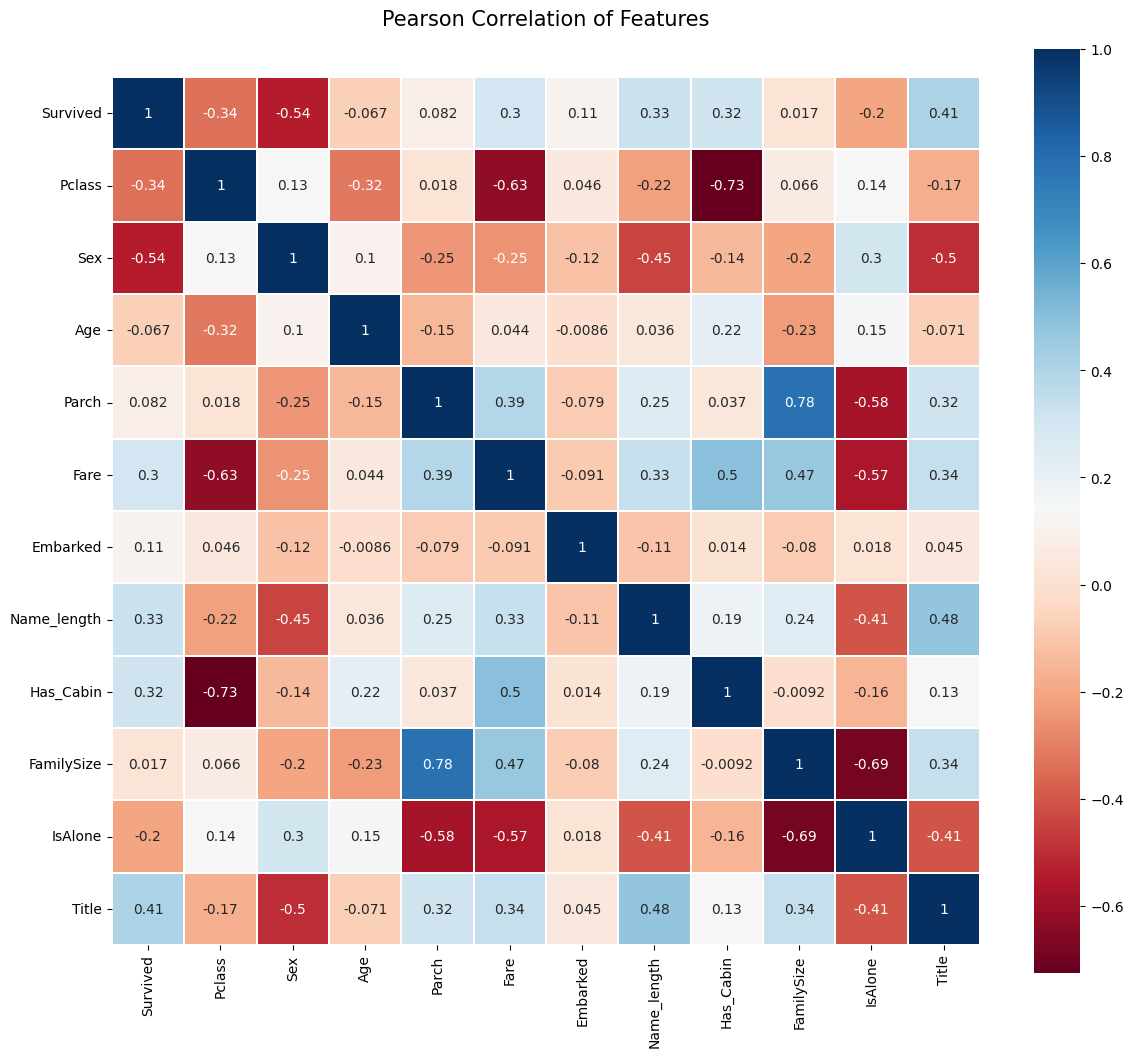

In [34]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


KeyboardInterrupt



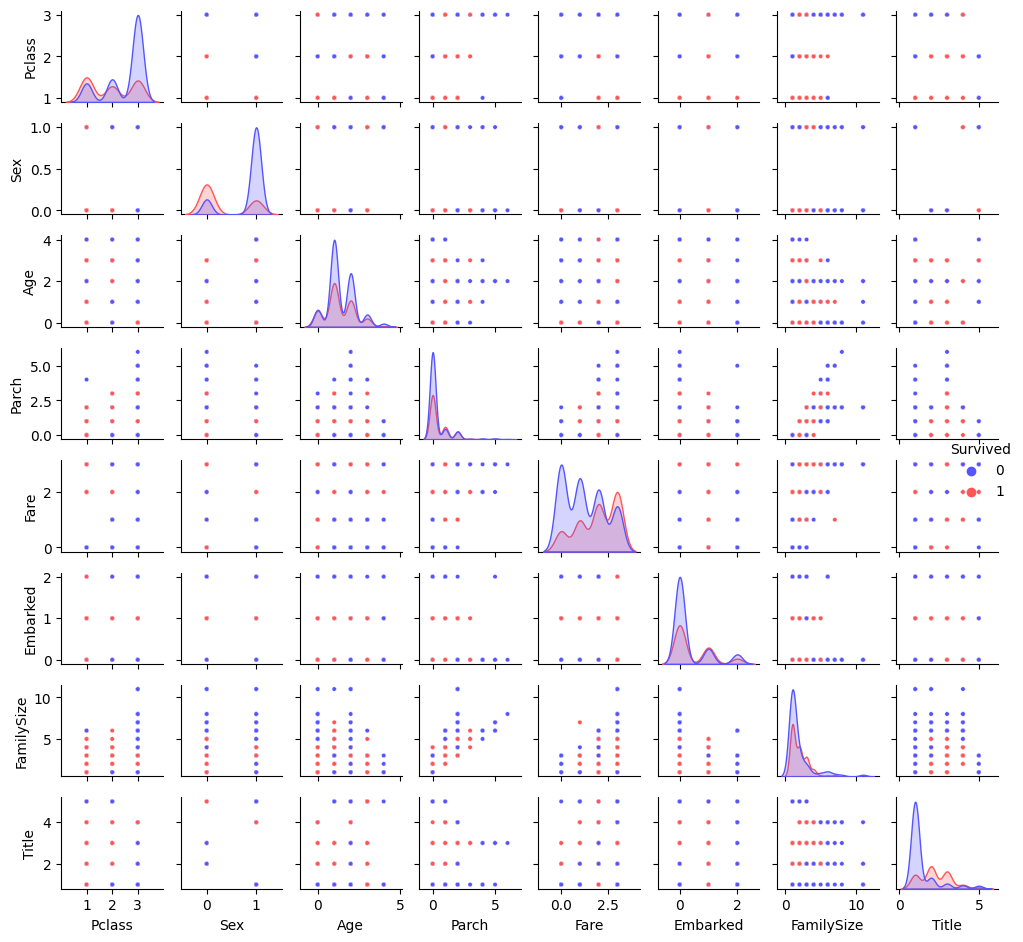

In [35]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

# Model Selection and Model Optimization Pipeline


RandomForestClassifier, SVC, GradientBoostingClassifier and LogisticRegression are used as basic algorithms, and XGBoost is used as a meta-algorithm

In [54]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

In [55]:
# Creating an instance for each algoritm with random_state=17 parameter
gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(random_state=17)
svc = SVC(random_state=17)
lr = LogisticRegression(random_state=17)

Configuring the meta-algorithm using GridSearchCV, the parameters below, and meta-features (using 5x validation and random_state=17 when defining the algorithm). The meta-features matrix is obtained from the predictions obtained by the basic algorithms on the validation data. 

In [57]:
# Hyperparameter dictionary for meta-algorithm for GridSearch
xgb_params = {'n_estimators': range(10, 100, 5),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [58]:
# An instance for CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [59]:
# An instance for XGBoost and an instance for GridSearch for XGB algorithm 
xgb = XGBClassifier(random_state=17)
xgb_gscv = GridSearchCV(xgb, xgb_params, cv=skf)

Build stacking (using 5-fold crossvalidation) for all models. The whole train.csv dataset is used as training data, and the whole test.csv dataset is used as test data. The meta-algorithm prediction for test.csv is done.

In [60]:
from sklearn.model_selection import cross_val_predict

In [61]:
models = [gbc, rfc, svc, lr]

In [62]:
# Creating a matrix of meta-features to train the meta-algorithm
meta_mtrx = np.empty((np.array(train.iloc[:, 1:]).shape[0], len(models)))

for n, model in enumerate(models):
    meta_mtrx[:, n] = cross_val_predict(estimator=model, X=train.iloc[:, 1:], y=train.iloc[:, 0], cv=skf, method="predict")
    models[n] = model.fit(train.iloc[:, 1:], train.iloc[:, 0])

In [47]:
# Training the meta-algorithm
meta_model = xgb_gscv.fit(meta_mtrx, train.iloc[:, 0])


KeyboardInterrupt



In [ ]:
# Creating a meta-features matrix for a meta-algorithm prediction on test data
meta_mtrx_test = np.empty((np.array(test).shape[0], len(models)))

for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(test)

In [ ]:
# Meta-algorithm prediction
meta_model_pred = meta_model.predict(meta_mtrx_test)

Creating a csv file with ensemble predictions to send to Kaggle

In [ ]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [ ]:
write_to_submission_file(meta_model_pred, PassengerId)

The result obtained at the competition:

0.76794